[hotels.csv](https://drive.google.com/file/d/1Qj0iYEbD64eVAaaBylJeIi3qvMzxf2C_/)

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Для корректного отображения фона в тёмной теме VS Code
plt.style.use('default')


In [49]:
df = pd.read_csv('hotels.csv')
df.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


Первоначальная версия датасета содержит 17 полей со следующей информацией:

* `hotel_address` — адрес отеля;
* `review_date` — дата, когда рецензент разместил соответствующий отзыв;
* `average_score` — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* `hotel_name` — название отеля;
* `reviewer_nationality` — страна рецензента;
* `negative_review` — отрицательный отзыв, который рецензент дал отелю;
* `review_total_negative_word_counts` — общее количество слов в отрицательном отзыв;
* `positive_review` — положительный отзыв, который рецензент дал отелю;
* `review_total_positive_word_counts` — общее количество слов в положительном отзыве.
* `reviewer_score` — оценка, которую рецензент поставил отелю на основе своего опыта;
* `total_number_of_reviews_reviewer_has_given` — количество отзывов, которые рецензенты дали в прошлом;
* `total_number_of_reviews` — общее количество действительных отзывов об отеле;
* `tags` — теги, которые рецензент дал отелю;
* `days_since_review` — количество дней между датой проверки и датой очистки;
* `additional_number_of_scoring` — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* `lat` — географическая широта отеля;
* `lng` — географическая долгота отеля.

In [51]:
df['review_date'] = pd.to_datetime(df['review_date'])

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [62]:
def null_finder (data):
    """_Искатель пропусков_

    Args:
        data (_pandas.core.frame.DataFrame_): _Датасет_

    Returns:
        _pandas.core.series.Series_: _столбцы с null и доля null в процентах_
    """
    cols_null_percent = data.isnull().mean() * 100
    cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
    return cols_with_null

null_finder(df)

lat    0.63288
lng    0.63288
dtype: float64

# 3. Машинное обучение для самых маленьких

После знакомых вам шагов подготовки датасета, а именно очистки, анализа, проектирования признаков и их преобразования, дата-сайентисты приступают к обучению модели. Для этого необходимо разделить датафрейм, создать, обучить и оценить качество модели.

Мы подготовили для вас [ноутбук](https://lms.skillfactory.ru/assets/courseware/v1/0a04828af83e98c62bf8782d920350d6/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/EDA_Project_3_model.ipynb) с кодом для обучения модели. Далее мы шаг за шагом разберём все описанные в нём действия.

## 1. РАЗДЕЛЕНИЕ НАБОРА ДАННЫХ

Прежде всего, для создания модели необходимо разделить датафрейм на набор данных, которые мы будем использовать для обучения модели, именуемый `X`, и на целевую переменную — величину, значение которой мы будем предсказывать, `y` (в нашем случае это рейтинг отелей).

<img src=p_3_img1.png>

Далее каждый из полученных наборов мы делим на **тренировочный** (`train`, используется для обучения модели) и **тестовый** (`test`, используется для оценки точности модели). Такое деление осуществляется с помощью специального метода [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) библиотеки `sklearn`. В параметрах метода (параметр `test_size`) мы указываем, какую часть исходного датафрейма нужно оставить для тестирования модели. В нашем коде эта часть составляет `25 %`, или `0.25`.

>Не существует идеального соотношения обучающей и тестовой выборки, однако принято выделять на часть обучения больше данных, около ⅔, а оставшуюся часть используют для проверки — ⅓ выборки. Таким образом, самые популярные значения параметра test_size составляют `0.3`, `0.25`, `0.2`.

In [59]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х — данные с информацией об отелях, у — целевая переменная (рейтинги отелей)  
X = df.drop(['reviewer_score'], axis = 1)  
y = df['reviewer_score']  
  
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
  
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" — для тестирования.  
# Для тестирования мы будем использовать 25 % от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# 2.СОЗДАНИЕ И ОБУЧЕНИЕ МОДЕЛИ

Сам процесс создания и тестирования модели занимает всего четыре строчки кода. В качестве алгоритма мы будем использовать популярный и довольно мощный алгоритм [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html). Он реализован в библиотеке sklearn.

In [47]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
      
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

# 3. ОЦЕНКА КАЧЕСТВА МОДЕЛИ

Для оценки качества модели — точности прогнозов, сделанных моделью, — мы будем использовать метрику (некий числовой показатель), которая называется `MAPE` (`mean absolute percentage error`), средняя абсолютная процентная ошибка. Эту метрику очень легко интерпретировать. Если у вас `MAPE = 11.4 %`, то это говорит о том, что ошибка составила `11.4 %` от фактических значений.

<img src=p_3_img2.png>

Для расчета `MAPE` сравним предсказанные нашей моделью значения с реальными и посмотрим на значение ошибки.


In [48]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test) и смотрим, насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений в отношении фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.1413542380524313


Итак, мы выяснили, что для корректной работы все данные в датафрейме, который вы будете использовать при обучении модели, должны быть в числовых форматах `int` или `float`. 

>Есть ещё одно ограничение: в столбцах не должно быть пропущенных значений. Вместо каждого пропущенного значения вам нужно будет вычислить и поместить в ячейку максимально близкое к реальности значение.

Таким образом, чтобы код, отвечающий за обучение модели, заработал, мы должны использовать в нём датафрейм, содержащий только количественные признаки и не содержащий пропущенных значений.

На первом этапе для создания такого датафрейма давайте просто удалим столбцы, содержащие данные типов `object` и `string` и заполним пропущенные значения каким-то одним значением (`unknown`, нулём или средним арифметическим) для всего столбца.

>Для выполнения этих операций вам понадобятся следующие методы библиотеки Pandas:
>
>[drop](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) — метод для удаления ненужных строк и столбцов (**обратите внимание**, что в материалах данного модуля этот метод разрешается использовать только для удаления столбцов);
>
>[fillna](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html) — метод для заполнения пропущенных значений в столбце или во всём датафрейме.

# Повысить точность прогнозов, которые делает модель, с помощью более тщательной подготовки данных.

Задачу, которая стоит перед вами, можно свести к пяти пунктам:

* **Удаление строковых значений**. Вам необходимо удалить из набора данных столбцы, данные в которых представлены не числами.
* **Очистка от пропущенных значений**. На предыдущем шаге мы делали это самым грубым из всех возможных способов, сейчас попробуйте подойти к процессу более гибко.
* **Создание новых признаков**. Мы попробуем создать новые столбцы с данными из существующих данных или с использованием внешних источников.
* **Преобразование признаков**. Применим различные преобразования над признаками вроде нормализации, стандартизации.
* **Отбор признаков**. Используем анализ мультиколлинеарности как шаг отбора признаков для модели.

**Ваша задача** — при помощи этих шагов и рекомендаций повысить качество предсказания. Чтобы понять, что качество улучшилось, ориентируйтесь на метрику MAPE: чем она меньше, тем лучше. Рассмотрим шаги подробнее.

## СТРОКОВЫЕ ДАННЫЕ

В исходном наборе данных всего девять столбцов содержат числовые данные. Так что просто удалить все object-значения и считать задачу выполненной не получится. Мы сделали это в прошлом юните, чтобы получить значение метрики. Но чтобы улучшить качество модели, вам перед удалением придётся очень основательно поработать со строковыми данными и извлечь из них как можно больше информации, которую можно представить в числовом виде.

## ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ

Мы уже говорили о том, что в задачах по машинному обучению принято не удалять строки с пустыми значениями, а заполнять их максимально близкими к реальности данными. Используйте знания из модулей очистки данных или вспомните о мере центральной тенденции в юнитах статистики. Попробуйте различные способы и ориентируйтесь на итоговую метрику.

## НОВЫЕ ПРИЗНАКИ

Это, пожалуй, самая творческая часть работы на данном шаге. Создание новых признаков потребует от вас способности вникать в контент, умения подключать к работе интуицию, творческого подхода и готовности к экспериментам. Попробуйте извлечь несколько признаков из даты, проанализируйте датасет на возможность добавления внешних источников данных. При наличии времени разберите текстовые столбцы на признаки.

## ПРЕОБРАЗОВАНИЕ ПРИЗНАКОВ

Данные могут быть представлены в невыгодном для модели свете. Используйте изученные вами способы преобразования данных, чтобы сделать данные качественнее.

## ОТБОР ПРИЗНАКОВ

Признаки могут дублировать информацию. Анализ мультиколлинеарности мы будем использовать, чтобы выбрать уникальные признаки для модели.

Также перед обучением (после разделения выборки на X и y) мы можем оценить значимость каждого признака для целевой переменной — рейтинг отеля. При помощи теста мы сможем узнать, как географическая долгота отеля и количество негативных отзывов влияют на его рейтинг.

>Для оценки значимости категориальных признаков будем использовать тест `хи-квадрат`, для непрерывных признаков — тест `ANOVA`.

Для начала разделим признаки по типу, перечислим их:

In [53]:
df.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [65]:
# непрерывные признаки
num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given']

# категориальные признаки
cat_cols = ['average_score', 'lat']

In [63]:
df = df.fillna({'lat':'unknown', 'lng':'unknown'})

In [66]:
y=y.astype('int')

...
from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

<AxesSubplot:>

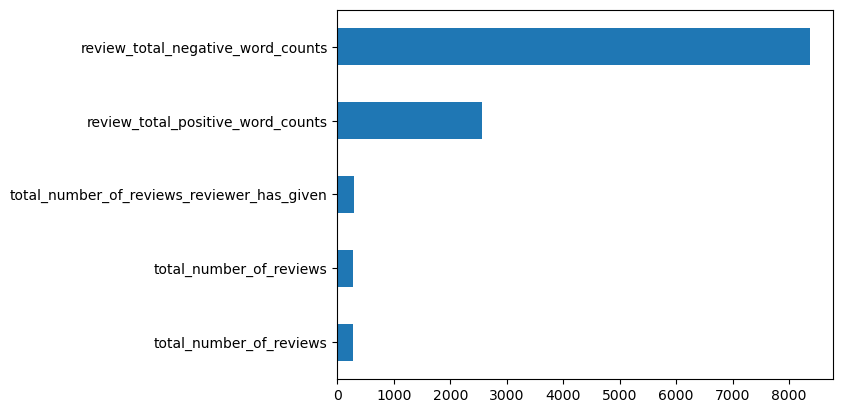

In [61]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [77]:
tags_list = []
for tags in df['tags']:
    tags_list.extend(tags)
print(tags_list)
